In [1]:
from utils import FocalLoss, f1
from wrn4 import *

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL

In [2]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN64 = Path('train64/')
TRAIN128 = Path('train128/')
TRAIN256 = Path('train256/')
TEST256 = Path('test256/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
train_names = list(seg.Id.values)

In [3]:
def open_image4d(fn:PathOrStr)->Image:
    "Return `Image` object created from image in file `fn`."
    x = PIL.Image.open(fn)
    return Image(pil2tensor(x).float().div_(255))

In [4]:
fname = train_names[0] + '.png'

In [5]:
im = open_image4d(TRAIN64/fname)

In [6]:
im, im.shape

(Image (4, 64, 64), torch.Size([4, 64, 64]))

In [7]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [8]:
seg.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [9]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, suffix='.png', label_delim=' ', fn_col=0, label_col=1)

In [10]:
seg.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18]


In [11]:
classes = uniqueify(np.concatenate(labels))

In [12]:
train, val = Image4C_ds.from_folder(PATH, TRAIN64, fnames, labels, valid_pct=0.2, classes=classes)

In [13]:
# train_dl = DataLoader(train, batch_size=128, num_workers=8)
# val_dl = DataLoader(val, batch_size=128, num_workers=8)

In [15]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [16]:
norm

functools.partial(<function _normalize_batch at 0x7f40a8c30730>, mean=tensor([0.4850, 0.4560, 0.4060, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250, 0.2250]))

In [17]:
data64 = ImageDataBunch.create(train_ds=train, valid_ds=val, ds_tfms=tfms, tfms=norm, bs=64, size=64)

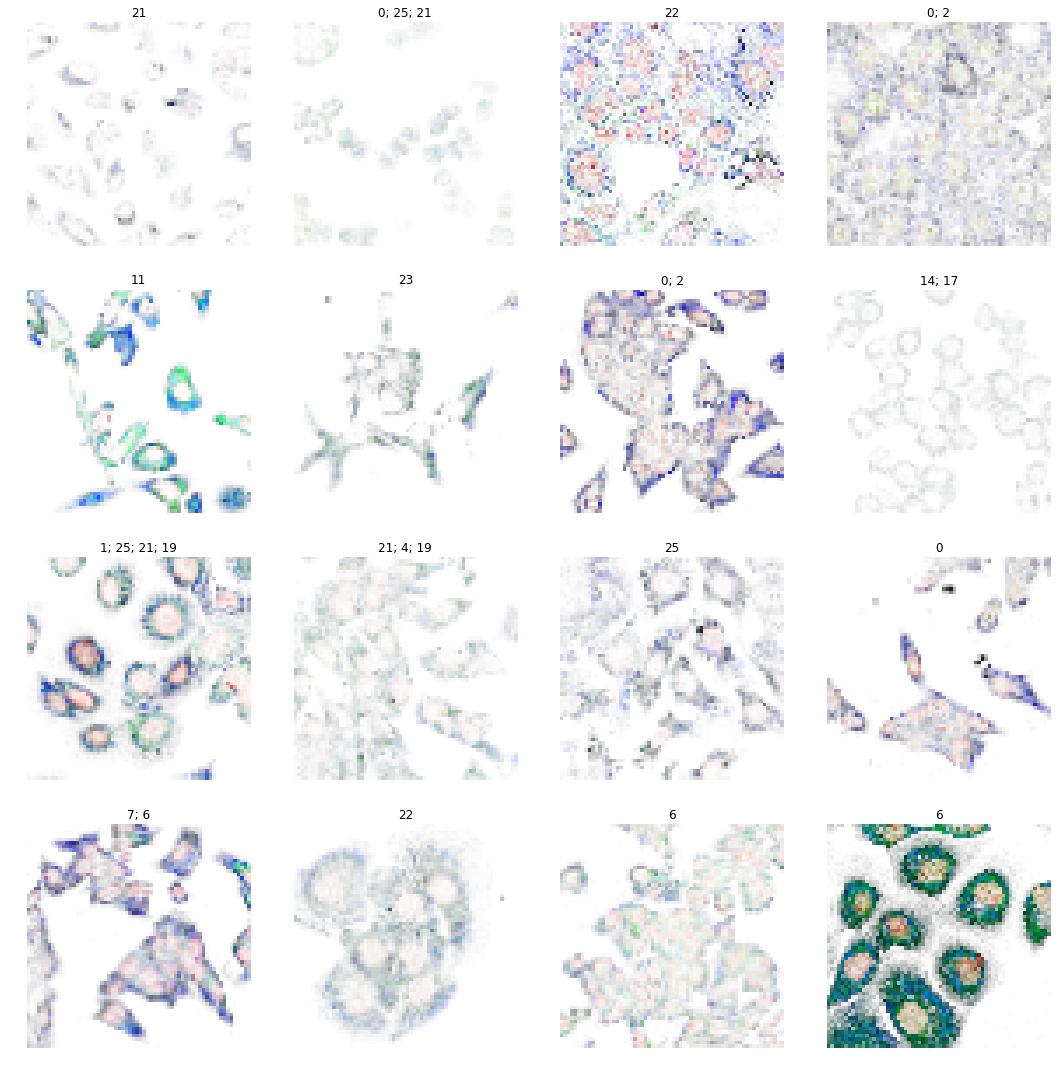

In [18]:
data64.show_batch(rows=4, figsize=(15,15))

In [19]:
# seg = pd.read_csv(PATH/MASKS)
# data64 = (ImageFileList.from_folder(PATH)
#         .label_from_df(seg, sep=' ', folder=TRAIN64, suffix='.png')  
#         .random_split_by_pct(0.2)
#         .datasets(Image4C_ds)  
#         .transform(tfms)             
#         .databunch()
#         .normalize(imagenet_stats))

In [20]:
from fastai.vision.models.wrn import *

In [21]:
def _bn(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv2d(ni, nf, ks, stride))

class BasicBlock(nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv2d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet4(nn.Module):
    def __init__(self, num_groups:int, N:int, num_classes:int, k:int=1, drop_p:float=0.0, start_nf:int=16):
        super().__init__()
        n_channels = [start_nf]
        for i in range(num_groups): 
            n_channels.append(start_nf*(2**i)*k) 
#             print(i)
#         print(n_channels)
        layers = [conv2d(4, n_channels[0], 3, 1)]  # conv1
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, (1 if i==0 else 2), drop_p)

        layers += [nn.BatchNorm2d(n_channels[3]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
                   Flatten(), nn.Linear(n_channels[3], num_classes)]
        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)


def wrn_22_4(): return WideResNet4(num_groups=3, N=3, num_classes=28, k=6, drop_p=0.)
def wrn_small_4(): return WideResNet4(num_groups=3, N=3, num_classes=28, k=6, drop_p=0., start_nf=4)

In [22]:
def f1(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>0.5).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [23]:
arch = wrn_22_4()

In [24]:
learn = Learner(data64, arch , metrics=[accuracy_thresh, f1])

In [25]:
# learn.lr_find()

In [26]:
# learn.recorder.plot()

In [27]:
# learn.to_fp16();

In [28]:
%time learn.fit_one_cycle(10, 1e-2)

Total time: 19:00
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.159711    0.181412    0.936555         0.302099  (01:54)
2      0.155923    0.188549    0.935507         0.215327  (01:55)
3      0.150317    0.403449    0.917240         0.108929  (01:54)
4      0.144646    0.153139    0.946019         0.260666  (01:54)
5      0.141695    0.151280    0.948348         0.293560  (01:53)
6      0.138253    0.151646    0.947197         0.327089  (01:53)
7      0.131234    0.136730    0.951963         0.378735  (01:53)
8      0.127837    0.131044    0.953535         0.456542  (01:53)
9      0.125195    0.127653    0.955209         0.437560  (01:53)
10     0.124727    0.127097    0.955164         0.436209  (01:53)

CPU times: user 11min 40s, sys: 7min 14s, total: 18min 54s
Wall time: 19min


In [29]:
learn.save('wrn4_64')

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.05)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.45, 0.55)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.9, 1.1111111111111112)}, p=0.75, resolved={}, do_run=True, is_random=True)]